<a href="https://colab.research.google.com/github/hydrationn/AI-based-Representation-and-Problem-Solving/blob/main/20240529_13%EC%A3%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5_2_%5BHands_On%5D_Understanding_Variational_Autoencoder_and_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Hands-On] Understanding Variational Autoencoder and Implementation

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

This lecture is part of the generative model series, specifically focusing on the use of Variational Autoencoders (VAEs) for image generation and reconstruction tasks.

## What is a Variational Autoencoder?
A Variational Autoencoder (VAE) is a type of generative model that learns to encode input data into a lower-dimensional latent space and then decode it back to the original space. Unlike traditional autoencoders, VAEs impose a probabilistic structure on the latent space, making it continuous and allowing for meaningful sampling and interpolation between points in the latent space.

## In this Notebook:
We will demonstrate the use of VAEs for generating and reconstructing images from the MNIST dataset. Starting with the basic VAE architecture, we will explore its capabilities in capturing the underlying data distribution and generating new data points.

### Objectives:
- Understand the basic structure and functioning of a Variational Autoencoder.
- Implement a VAE to learn and reconstruct the MNIST dataset.
- Evaluate the performance and visualize the reconstructed images.
- Analyze the latent space representation and its role in generating diverse data variations.
- Enhance the latent space dimensionality to improve reconstruction quality.

By the end of this lecture, you will gain practical insights into the workings of Variational Autoencoders, understand the importance of continuous latent spaces, and recognize the potential for further advancements in generative modeling.

Let's dive into the fascinating world of Variational Autoencoders!

In [26]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [27]:
# Function to set the seed for reproducibility
import random
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # The below two lines are for deterministic algorithm behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset Preparation
The MNIST dataset consists of 70,000 images of handwritten digits (0-9), each of size 28x28 pixels. It is a widely used benchmark in the field of machine learning for image classification and generation tasks.


In [28]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

## VAE Architecture Explanation
The Variational Autoencoder (VAE) consists of an encoder and a decoder. The encoder compresses the input data into a lower-dimensional latent space, characterized by a mean and a log variance (logvar). The decoder reconstructs the input data from the latent space.

1. **Encoder:**
   - `fc1`: A fully connected layer that transforms the input into a hidden representation.
   - `fc2_mean` and `fc2_logvar`: Fully connected layers that produce the mean and log variance of the latent space distribution.

2. **Reparameterization Trick:**
   - The `reparameterize` function generates latent variables `z` by sampling from a Gaussian distribution using the mean and log variance. This allows the gradient to backpropagate through the sampling process.

3. **Decoder:**
   - `fc3` and `fc4`: Fully connected layers that reconstruct the input data from the latent variable `z`.

The VAE is instantiated with an input dimension of 28x28 (for MNIST), a hidden dimension of 400, and a latent dimension of 20.



In [29]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean of latent variables
        self.fc22 = nn.Linear(400, latent_dim)  # Log-variance of latent variables
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28 * 28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Loss Function for VAE
The loss function for a VAE is a combination of the reconstruction loss and the KL divergence. The reconstruction loss ensures that the output is similar to the input, while the KL divergence ensures that the latent space is properly regularized.



In [30]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## Training
We train the VAE by optimizing the combined loss function using an optimizer like Adam.


In [31]:
# Training the VAE with 2D latent space
latent_dim = 2
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _ in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data) ##
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(trainloader.dataset)}')

Epoch 1, Loss: 204.0406488606771
Epoch 2, Loss: 175.16311482747395
Epoch 3, Loss: 167.85291393229167
Epoch 4, Loss: 164.47331458333332
Epoch 5, Loss: 162.4912618815104
Epoch 6, Loss: 161.04716041666666
Epoch 7, Loss: 159.95039291992188
Epoch 8, Loss: 159.11640888671874
Epoch 9, Loss: 158.24447039388022
Epoch 10, Loss: 157.5468673828125
Epoch 11, Loss: 156.93479713541666
Epoch 12, Loss: 156.40116446940104
Epoch 13, Loss: 155.91680974934897
Epoch 14, Loss: 155.42135237630208
Epoch 15, Loss: 155.02564326171876
Epoch 16, Loss: 154.56711048177084
Epoch 17, Loss: 154.19579086914064
Epoch 18, Loss: 153.80021772460938
Epoch 19, Loss: 153.50310618489584
Epoch 20, Loss: 153.1710676595052
Epoch 21, Loss: 152.88291513671874
Epoch 22, Loss: 152.57873567708333
Epoch 23, Loss: 152.32029664713542
Epoch 24, Loss: 152.006349609375
Epoch 25, Loss: 151.73085006510416
Epoch 26, Loss: 151.45326663411458
Epoch 27, Loss: 151.23935634765624
Epoch 28, Loss: 151.03262125651042
Epoch 29, Loss: 150.82153515625
Epo

## Generating New Data
After training, we can use the decoder part of the VAE to generate new data by sampling from the latent space.

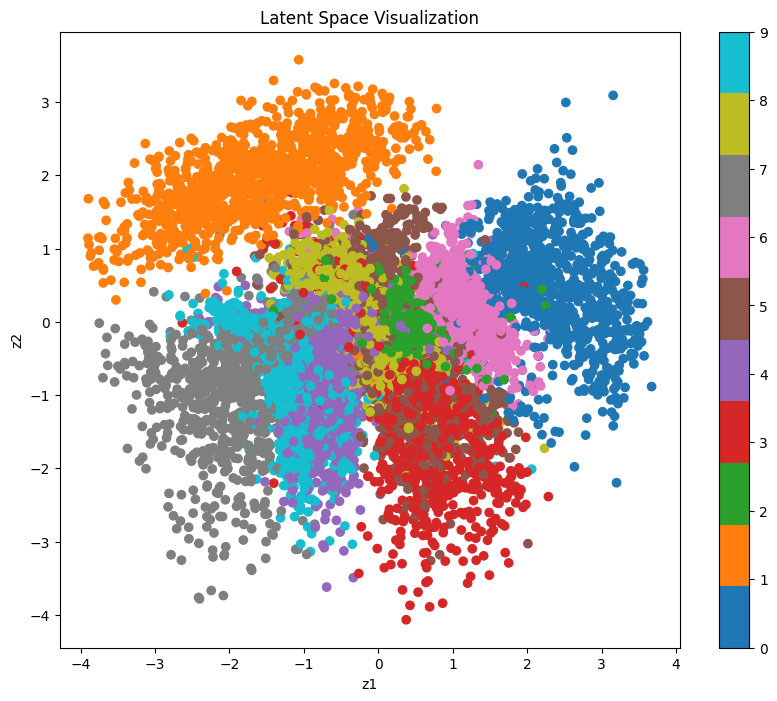

In [32]:
# Visualizing the latent space
model.eval()
all_z = []
all_labels = []
with torch.no_grad():
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=64, shuffle=False)

    for data, labels in testloader:
        data = data.to(device)
        mu, logvar = model.encode(data.view(-1, 28 * 28))
        z = model.reparameterize(mu, logvar)
        z = z.cpu().numpy()

        all_z.append(z)
        all_labels.append(labels)

    all_z = np.concatenate(all_z)
    all_labels = np.concatenate(all_labels)

    plt.figure(figsize=(10, 8))
    plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10')
    plt.colorbar()
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space Visualization')
    plt.show()

## Adjusting and Visualizing the Continuous Latent Space in VAE
A VAE leverages a continuous latent space to generate diverse variations of data. By sampling from this latent space, we can create new data points, which can be adjusted in various ways through meaningful manipulations within the latent space.

Manipulating this latent space is useful for controlling specific attributes of the data or generating new data. For example, with the MNIST dataset, we can visualize the transformation of the digit '1' to '7' by moving through the latent space. This demonstrates that the model has learned a latent space capable of capturing continuous variations between digits.

The following code allows sampling from the latent space to generate new data and visualizes it by plotting.


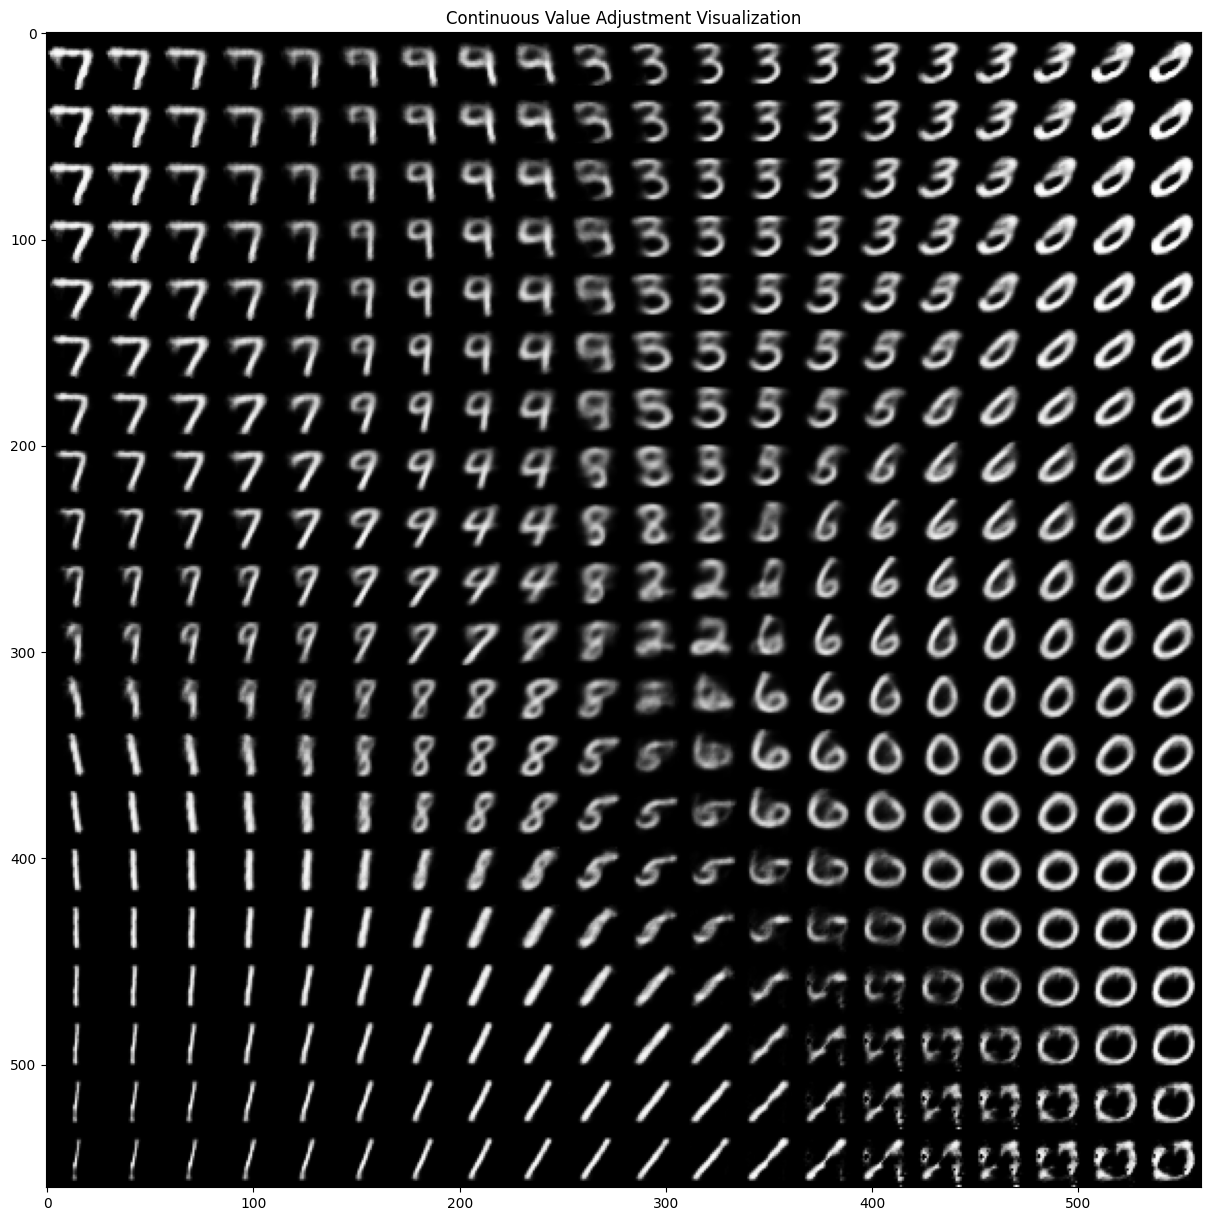

In [33]:
# Continuous value adjustment visualization
with torch.no_grad():
    grid_x = np.linspace(-3, 3, 20)
    grid_y = np.linspace(-3, 3, 20)
    figure = np.zeros((28 * 20, 28 * 20))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = torch.Tensor([[xi, yi]]).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded.view(28, 28).cpu().numpy()
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

    plt.figure(figsize=(15, 15))
    plt.imshow(figure, cmap='gray')
    plt.title('Continuous Value Adjustment Visualization')
    plt.show()

## Enhancing the Latent Space

At this point, we can see that it is challenging to generate fully intact images with a simple 2-dimensional vector representation. To address this, we will maintain the structure of the VAE but increase the dimensionality of the bottleneck latent space. This will allow us to train the model again and observe the results, aiming for improved reconstruction quality.


In [34]:
# Training the VAE with higher dimensional latent space
latent_dim = 200
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _ in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(trainloader.dataset)}')


Epoch 1, Loss: 197.8713826497396
Epoch 2, Loss: 147.68214440104165
Epoch 3, Loss: 136.34541892903647
Epoch 4, Loss: 127.8776143717448
Epoch 5, Loss: 121.36412233072916
Epoch 6, Loss: 116.77025463867187
Epoch 7, Loss: 113.73223460286458
Epoch 8, Loss: 111.66097649739584
Epoch 9, Loss: 110.27103701171875
Epoch 10, Loss: 109.20086204427083


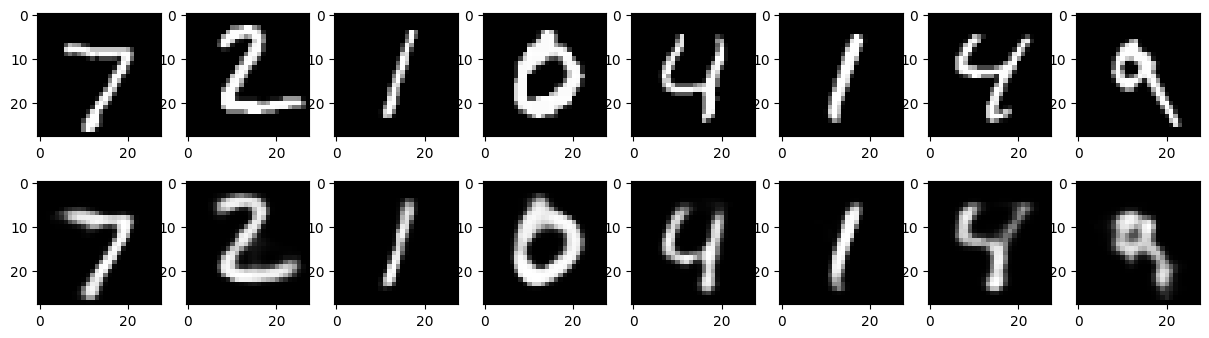

In [35]:
# Visualizing the reconstruction with higher dimensional latent space
model.eval()
with torch.no_grad():
    data, _ = next(iter(testloader))
    data = data.to(device)
    recon, _, _ = model(data)
    recon = recon.view(-1, 1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        axes[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
    plt.show()


## Conclusion

In this hands-on tutorial, we explored the concept and implementation of Variational Autoencoders (VAEs) using PyTorch. We began by understanding the basic structure of a VAE, including the encoder, decoder, and the reparameterization trick that allows for gradient-based optimization. We then delved into the MNIST dataset to train our VAE model and observed how it learns to encode and decode handwritten digit images.

We also discussed the importance of the latent space in a VAE and how increasing its dimensionality can improve the quality of the generated images. By manipulating the continuous latent space, we can generate diverse variations of data, showcasing the powerful generative capabilities of VAEs.